King, 1/23/20, A Random Forest Model was used, Estimated AUC = .829

In [1]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [2]:
# Load the data
train_url = 'https://raw.githubusercontent.com/JimKing100/blue_owl/master/data/train.csv'
test_url  = 'https://raw.githubusercontent.com/JimKing100/blue_owl/master/data/test.csv'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

In [3]:
# Split training data into training and validation sets 90/10 
train, val = train_test_split(train, train_size=0.90, test_size=0.10, random_state=42)
print(train.shape, val.shape, test.shape)

(9000, 10) (1000, 10) (10000, 9)


In [4]:
# Initialize
target = 'outcome'
features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [5]:
# Optimize the RF Model

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
  
pipeline = make_pipeline (
  ce.OrdinalEncoder(), 
  SimpleImputer(strategy='mean'),
  RandomizedSearchCV(estimator = RandomForestRegressor(),
                     param_distributions = random_grid,
                     n_iter = 5,
                     verbose=2,
                     random_state=42,
                     n_jobs = -1)
  )

pipeline.fit(X_train, y_train)

pd.set_option('display.max_rows', 200)
model = pipeline.named_steps['randomizedsearchcv']
best = pd.Series(model.best_params_)
print(best)

{'n_estimators': [200, 233, 266, 300, 333, 366, 400, 433, 466, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/JKMacBook/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   35.7s finished


n_estimators          200
min_samples_split      10
min_samples_leaf        2
max_features         sqrt
max_depth              26
bootstrap            True
dtype: object


In [6]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=200,
                           min_samples_split=10,
                           min_samples_leaf=2,
                           max_depth=26,
                           bootstrap=True,
                           random_state=42,
                           verbose=1)
)

In [7]:
# Get validation score
pipeline.fit(X_train, y_train)
print ('Validation Accuracy', pipeline.score(X_val, y_val))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Validation Accuracy 0.929


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


In [8]:
# Calculate the ROC/AUC score for validation data
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


0.8290598914249022

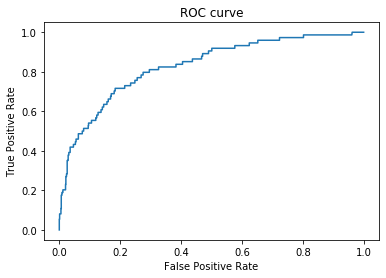

In [9]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val==1, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [10]:
# Predictions of all observations in the test dataset
pred = pipeline.predict(test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished


In [11]:
# First five predicted values of outcome in the test dataset
pred[0:5]

array([0, 0, 0, 0, 0])